In [1]:
# Configuration to automatically reload modified modules
%load_ext autoreload
%autoreload 2

# This allows changes in imported modules to be reflected automatically
# without needing to restart the kernel

# Data and Preprocessing

## Build Data Frame with Corpus

In [2]:
from utils import build_corpus_dataframe

In [3]:
corpus_path = "data/Corpus-representacion"
corpus_raw = build_corpus_dataframe(corpus_path)

In [24]:
corpus_raw.columns

Index(['category', 'document_id', 'content'], dtype='object')

In [4]:
# df_corpus.to_csv("data/data_raw.csv", index=False)

In [5]:
for idx, row in corpus_raw.groupby("category").first().iterrows():
    print(f"Category: {idx}")
    print(f"Document ID: {row['document_id']}")
    print(f"Content: {row['content']}")
    print("-" * 40)

Category: comp.sys.ibm.pc.hardware
Document ID: 58980
Content: Newsgroups: comp.sys.ibm.pc.hardware
Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!agate!boulder!ucsu!rintintin.Colorado.EDU!studner
From: studner@rintintin.Colorado.EDU (STUDNER  ROGER ALAN)
Subject: Modem for Sale
Message-ID: <1993Apr6.174054.5832@ucsu.Colorado.EDU>
Sender: news@ucsu.Colorado.EDU (USENET News System)
Nntp-Posting-Host: rintintin.colorado.edu
Organization: University of Colorado, Boulder
Date: Tue, 6 Apr 1993 17:40:54 GMT
Lines: 4

I am selling a USR HST 14.4k baud modem with v42bis compression upgrades.
THere is no manual, as it was lost going from one side of the U.S. to the other at some point.  THe modem is setup for max throughput, and it has built in help, but a quick reference guide on the bottom of it, so its use it not difficult by any means.
Any offers?


----------------------------------------
Category: comp.sys.mac.hardwar

## Initial Corpus Cleaning

In [6]:
from text_preprocessing import clean_header, preprocessing_pipeline, remove_writes_lines


corpus_clean_df = corpus_raw.copy()

corpus_clean_df["cleaned_content"] = (
    corpus_clean_df["content"].apply(clean_header).apply(remove_writes_lines)
)

In [7]:
# corpus_clean_df["cleaned_content"].to_csv("data/corpus_cleaned.csv", index=False)

In [8]:
for _idx, row in corpus_clean_df.sample(frac=1).iloc[:10].iterrows():
    print(f"Category: {row['category']}\n")
    print(f"Document ID: {row['document_id']}\n")
    print(f"Cleaned Content: {row['cleaned_content']}\n")
    print("-" * 40)

Category: sci.electronics

Document ID: 53549

Cleaned Content: >That's scary -- if there's a way to set an arbitrary mileage figure
>into the odometer, you can't trust *any* odometer reading, even
>if you can prove that the odometer itself is the same one that
>came on the car originally.

  I was wondering if anyone can shed any light on just how it is that these
electronic odometers remember the total elapsed mileage?  What kind of
memory is stable/reliable enough, non-volatile enough and independent enough
(of outside battery power) to last say, 10 years or more, in the life of a
vehicle?  I'm amazed that anything like this could be expected to work for
this length of time (especially in light of all the gizmos I work with that
are doing good to work for 2 months without breaking down somehow).

Side question:  how about the legal ramifications of selling a used car with
a replaced odometer that starts over at 0 miles, after say 100/200/300K
actual miles.  Looks like fraud would be

## Preprocessing

In [9]:
corpus_clean_and_preprocessed_df = corpus_clean_df.copy()
corpus_clean_and_preprocessed_df["preprocessed_content_for_vsm"] = preprocessing_pipeline(
    corpus_clean_and_preprocessed_df["cleaned_content"]
)
corpus_clean_and_preprocessed_df["preprocessed_content_for_embedding"] = preprocessing_pipeline(
    corpus_clean_and_preprocessed_df["cleaned_content"], lemmatize=False
)

Processing documents...: 100%|██████████| 805/805 [00:42<00:00, 18.96it/s]


In [30]:
corpus_clean_and_preprocessed_df.head(2)

,category,document_id,content,cleaned_content,preprocessed_content_for_vsm,preprocessed_content_for_embedding
0,talk.politics.mideast,75406,Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv....,[ stuff deleted ]\n |> I wrote:\n |> Are y...,stuff delete i write be you call name or give ...,stuff deleted i wrote are you calling names or...
1,talk.politics.mideast,75401,Newsgroups: talk.politics.mideast\nPath: canta...,|> In article <C50wJJ.J4r@newsflash.concordia....,in article c50wjj.j4r@newsflash.concordia.ca i...,in article c50wjj.j4r@newsflash.concordia.ca i...


# Vector Space Model

In [11]:
from vectorizing import vectorize_text

In [82]:
corpus_clean_and_preprocessed_df["preprocessed_content_for_embedding"].iloc[0]

"stuff deleted i wrote are you calling names or giving me a title if the first read your paragraph above if not i accept the title in order to let you get into the um well debate again hasan replies i didnot know that master of wisdom can be name clling too unless you consider yourself deserve less unless you are referring to someone else you have in fact given me a name i did not ask for hence the term name calling so what do you expect me to tell you to tell you master of wsidom i replied if you insist on giving me names titles i did not ask for you could at least spell them correctly /sigh hasan gloats that was only to confuse you ha ha ha hey hell bent on retarding into childhood no |>when you are intentionally neglecting the most important fact that |>the whole israeli presence in the occupied territories is illegitimate |>and hence all their actions their courts their laws are illegitimate on |>the ground of occupied territories no i am not neglecting that i 'm merely asking you 

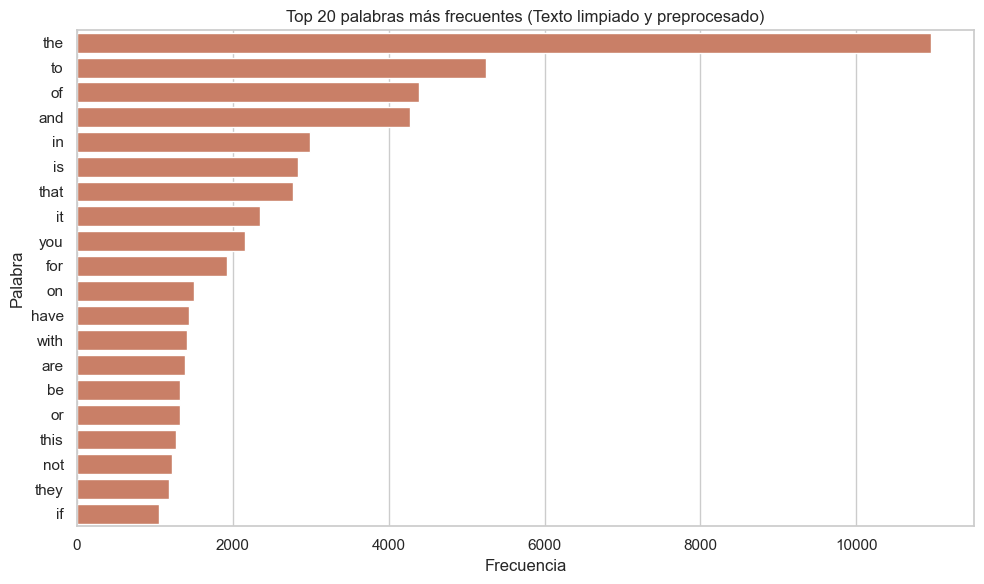

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


vectors, vocab = vectorize_text(
    corpus_clean_and_preprocessed_df["preprocessed_content_for_embedding"], method="bow"
)

# Sum total occurrences of each word in the BoW matrix
word_counts = np.asarray(vectors.sum(axis=0)).flatten()


# np.argsort(word_counts) returns the indices that would sort the array from smallest to largest (ascending).
# Therefore, [::-1] reverses the order to obtain from largest to smallest (descending).
# [:top_n] selects the first top_n indices (the most frequent words).
sorted_indices = np.argsort(word_counts)[::-1][:20]
inv_vocab = {idx: word for word, idx in vocab.items()}
top_words = [inv_vocab[idx] for idx in sorted_indices]
top_counts = word_counts[sorted_indices]

# Crear el plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_counts, y=top_words, color="#d97757")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.title("Top 20 palabras más frecuentes (Texto limpiado y preprocesado)")
plt.tight_layout()
plt.show()

In [ ]:
tf_vectors, tf_vocab = vectorize_text(
    corpus_clean_and_preprocessed_df["preprocessed_content_for_vsm"], method="bow"
)
tfidf_vectors, tfidf_vocab = vectorize_text(
    corpus_clean_and_preprocessed_df["preprocessed_content_for_vsm"], method="tfidf"
)

assert tf_vocab == tfidf_vocab, "Vocabulary mismatch between BOW and TF-IDF methods"

## Save Vectors

To save the TF-IDF and BOW vectors

### SciPy (.npz) (Recommended for large sparse matrices)
- **Advantages**: Maintains sparse format, very memory efficient
- **Disadvantages**: Requires saving vocabulary separately

In [15]:
from vectorizing import save_vectors_scipy  # , load_vectors_scipy

In [16]:
save_vectors_scipy(tf_vectors, tf_vocab, "data/VSM/tf_vectors")
save_vectors_scipy(tfidf_vectors, tfidf_vocab, "data/VSM/tfidf_vectors")
# tf_vectors, tf_vocab = load_vectors_scipy("data/VSM/tf_vectors")
# tfidf_vectors, tfidf_vocab = load_vectors_scipy("data/VSM/tfidf_vectors")

Sparse matrices saved to data/VSM/tf_vectors.npz
Sparse matrices saved to data/VSM/tfidf_vectors.npz


# Embeddings Space Model

In [17]:
from embedding import create_sentence_embeddings, load_model, save_embeddings  # , load_embeddings

In [18]:
embedding_model = load_model("fasttext-wiki-news-subwords-300")

Loading model: fasttext-wiki-news-subwords-300...


## Average

In [19]:
sentence_embeddings = create_sentence_embeddings(
    corpus_clean_and_preprocessed_df["preprocessed_content_for_embedding"], model=embedding_model
)

save_embeddings(sentence_embeddings, filepath="data/ESM/average_sentence_embeddings")

# loaded_embeddings = load_embeddings("data/ESM/average_sentence_embeddings.npz")
# print(f"Embeddings cargados con shape: {loaded_embeddings.shape}")

Processing 805 documents...


Processing documents...: 100%|██████████| 805/805 [00:01<00:00, 620.05it/s] 

Embeddings saved at: data/ESM/average_sentence_embeddings


## Sum

In [20]:
sentence_embeddings = create_sentence_embeddings(
    corpus_clean_and_preprocessed_df["preprocessed_content_for_embedding"],
    model=embedding_model,
    method="additive",
)

save_embeddings(sentence_embeddings, filepath="data/ESM/additive_sentence_embeddings")

# loaded_embeddings = load_embeddings("data/ESM/additive_sentence_embeddings.npz")
# print(f"Embeddings cargados con shape: {loaded_embeddings.shape}")

Processing 805 documents...


Processing documents...: 100%|██████████| 805/805 [00:00<00:00, 1845.20it/s]



Embeddings saved at: data/ESM/additive_sentence_embeddings
